In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE


In [2]:

# ------------------------- Hampel Filter Function -------------------------
def hampel_filter(input_series, window_size=10, n_sigmas=3):
    """Apply Hampel filter to a pandas series."""
    new_series = input_series.copy()
    k = 1.4826  # Scale factor for Gaussian distribution
    rolling_median = input_series.rolling(window=2 * window_size, center=True).median()
    MAD = k * (input_series.rolling(window=2 * window_size, center=True)
               .apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True))
    diff = np.abs(input_series - rolling_median)
    outlier_idx = diff > n_sigmas * MAD
    new_series[outlier_idx] = rolling_median[outlier_idx]
    return new_series


In [3]:

# ------------------------- Load and Preprocess Data -------------------------
df = pd.read_csv('BTC_DATA.csv')

# Select the relevant features
features = [
    'sentinusdUSD', 'transactionfeesUSD', 'difficulty14std', 
    'activeaddresses7std', 'mining_profitability90trx', 'activeaddresses3std',
    'transactions3std', 'difficulty90mom', 'hashrate90mom', 'difficulty7std',
    'price90momUSD', 'difficulty30mom', 'transactionvalue90momUSD', 
    'fee_to_reward3stdUSD', 'mining_profitability30trx', 'difficulty3std',
    'size3std', 'hashrate30mom', 'sentinusd90momUSD'
]


In [4]:

missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print("Missing features:", missing_features)
    features = [f for f in features if f in df.columns]

X = df[features].copy()
X = X.fillna(X.median())

# Apply the Hampel filter to each feature for robust outlier handling
for col in X.columns:
    X[col] = hampel_filter(X[col])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:

# ------------------------- Save Cleaned Data -------------------------
cleaned_df = pd.DataFrame(X_scaled, columns=features)
cleaned_df.to_csv("cleaned_BTC_features.csv", index=False)
print(" Cleaned data saved as 'cleaned_BTC_features.csv'.")


 Cleaned data saved as 'cleaned_BTC_features.csv'.


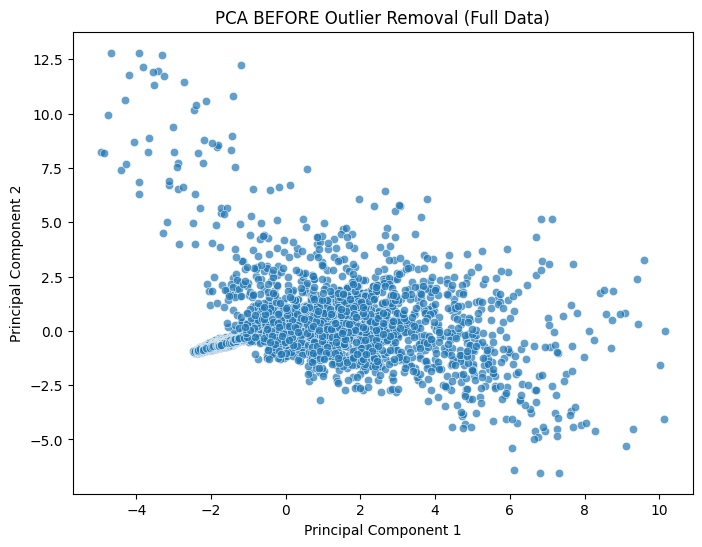

PCA BEFORE: Explained Variance Ratio: [0.25960512 0.12548627]


In [6]:

# ========================= PCA BEFORE Outlier Removal =========================
pca_before = PCA(n_components=2, random_state=42)
X_pca_before = pca_before.fit_transform(X_scaled)
pca_before_df = pd.DataFrame(X_pca_before, columns=['PC1', 'PC2'])

# Plot the PCA before outlier removal
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_before_df, x='PC1', y='PC2', alpha=0.7)
plt.title("PCA BEFORE Outlier Removal (Full Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

print("PCA BEFORE: Explained Variance Ratio:", pca_before.explained_variance_ratio_)


Isolation Forest Outlier Ratio: 5.01%


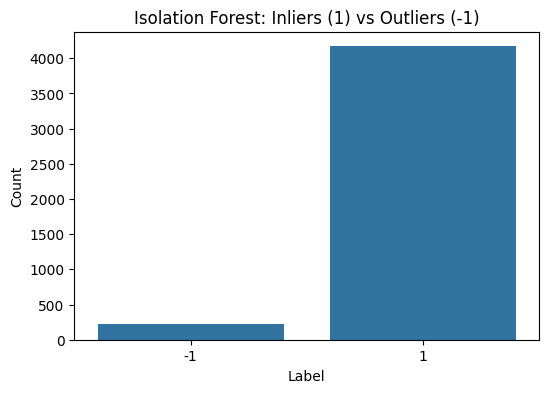

In [7]:

# ========================= Isolation Forest for Outlier Detection =========================
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X_scaled)
df['Outlier'] = outlier_labels  # -1 for outlier, 1 for inlier

outlier_ratio = (df['Outlier'] == -1).mean()
print(f"Isolation Forest Outlier Ratio: {outlier_ratio:.2%}")

plt.figure(figsize=(6, 4))
sns.countplot(x=df['Outlier'])
plt.title("Isolation Forest: Inliers (1) vs Outliers (-1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


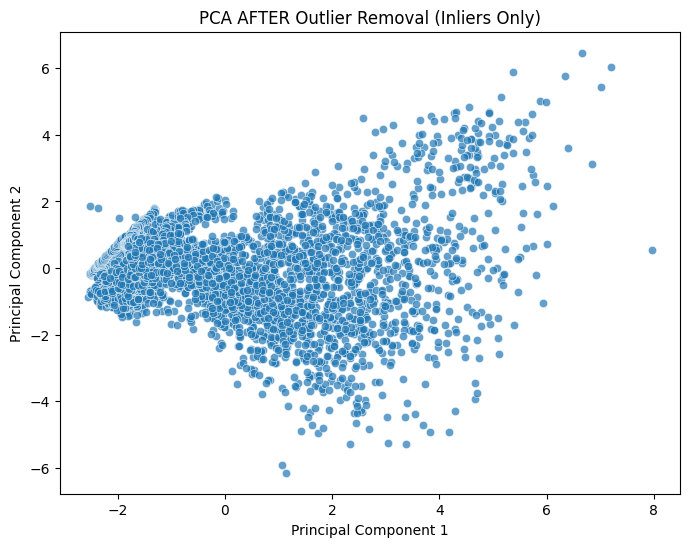

PCA AFTER: Explained Variance Ratio: [0.31417999 0.14477055]


In [8]:

# ========================= PCA AFTER Outlier Removal =========================
inlier_mask = outlier_labels == 1
X_scaled_inliers = X_scaled[inlier_mask]

pca_after = PCA(n_components=2, random_state=42)
X_pca_after = pca_after.fit_transform(X_scaled_inliers)
pca_after_df = pd.DataFrame(X_pca_after, columns=['PC1', 'PC2'])

# Plot the PCA after outlier removal
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_after_df, x='PC1', y='PC2', alpha=0.7)
plt.title("PCA AFTER Outlier Removal (Inliers Only)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

print("PCA AFTER: Explained Variance Ratio:", pca_after.explained_variance_ratio_)


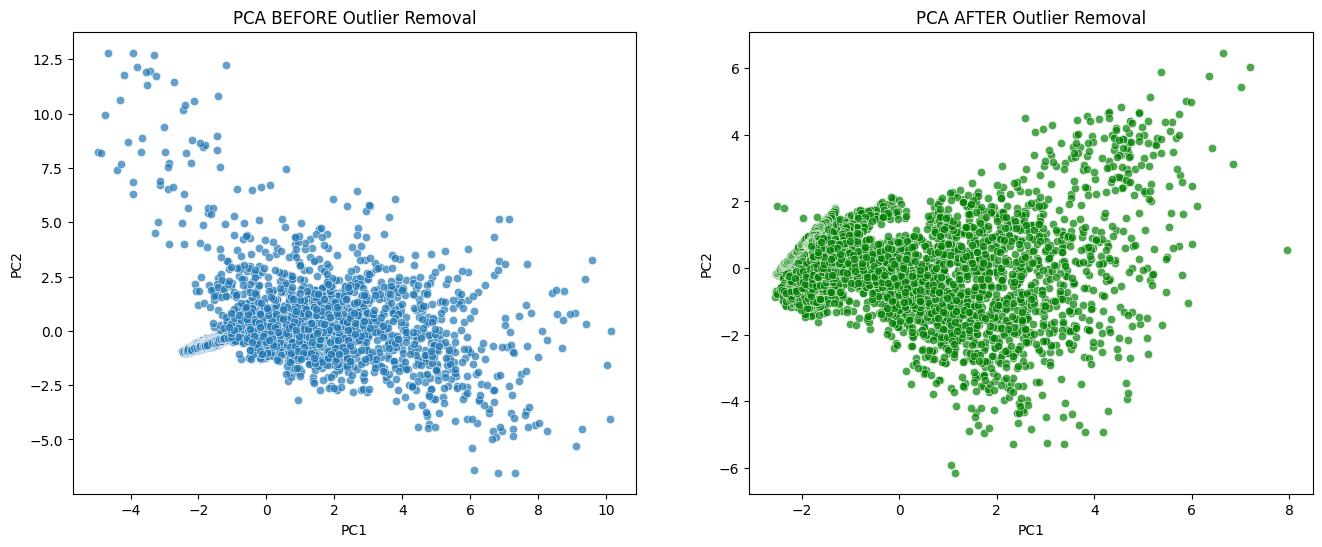

In [9]:

# ========================= Side-by-Side PCA Comparison =========================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(ax=axes[0], data=pca_before_df, x='PC1', y='PC2', alpha=0.7)
axes[0].set_title("PCA BEFORE Outlier Removal")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

sns.scatterplot(ax=axes[1], data=pca_after_df, x='PC1', y='PC2', alpha=0.7, color='green')
axes[1].set_title("PCA AFTER Outlier Removal")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.show()


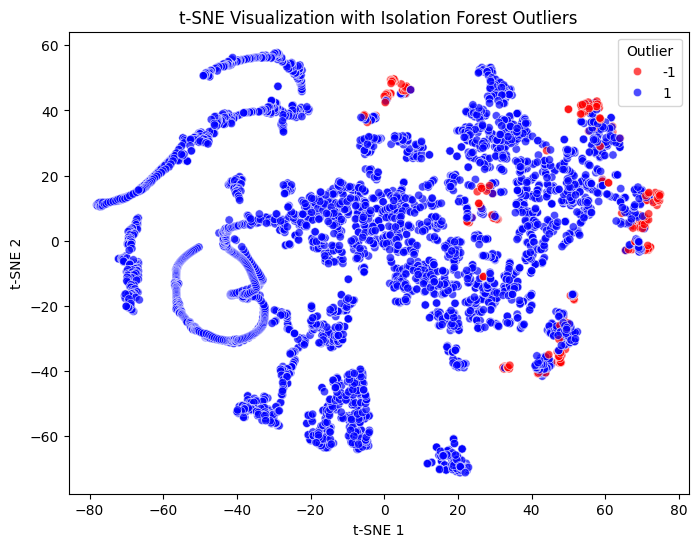

In [10]:

# ------------------------- t-SNE Visualization -------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(X_tsne, columns=['tSNE1', 'tSNE2'])
tsne_df['Outlier'] = outlier_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='Outlier', data=tsne_df, palette=['red', 'blue'], alpha=0.7)
plt.title("t-SNE Visualization with Isolation Forest Outliers")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [11]:

# ------------------------- KMeans Clustering -------------------------
k = 3  # Example: use 3 clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)
df['KMeans_Cluster'] = clusters_kmeans


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


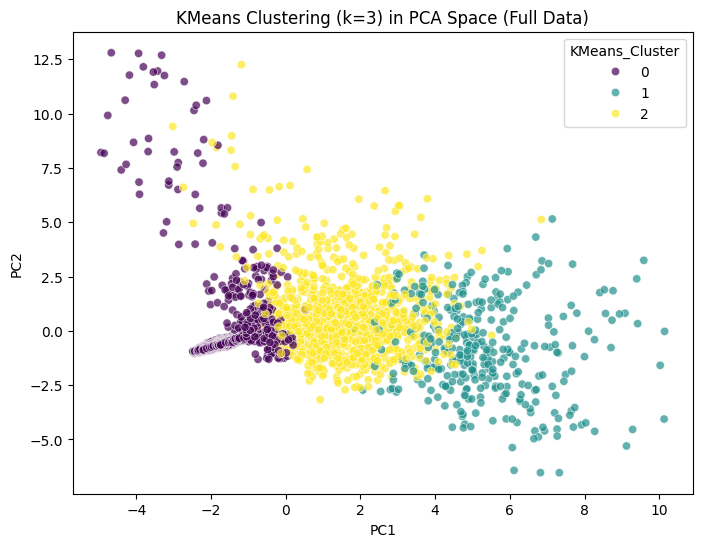

KMeans Silhouette Score: 0.2849


In [12]:

# Visualize KMeans clusters on PCA BEFORE (full data)
pca_before_df['KMeans_Cluster'] = clusters_kmeans
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_before_df, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis', alpha=0.7)
plt.title("KMeans Clustering (k=3) in PCA Space (Full Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
print("KMeans Silhouette Score: {:.4f}".format(silhouette_kmeans))


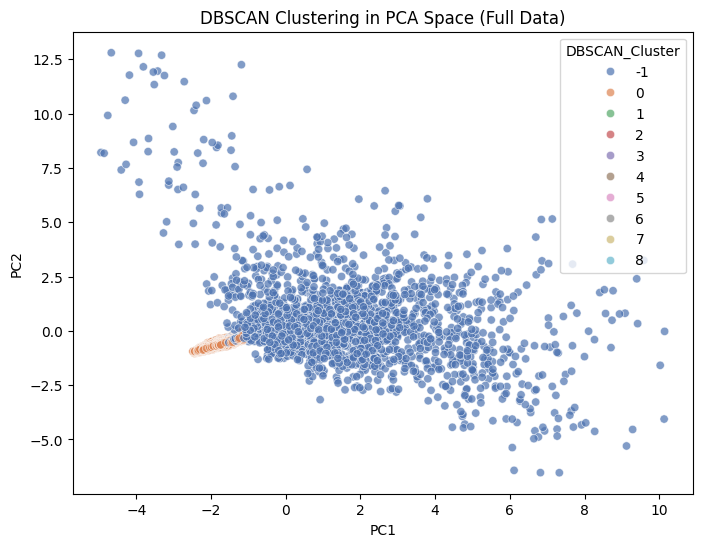

DBSCAN Silhouette Score (non-noise points): -0.1763


In [13]:

# ------------------------- DBSCAN Clustering -------------------------
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)
df['DBSCAN_Cluster'] = clusters_dbscan
pca_before_df['DBSCAN_Cluster'] = clusters_dbscan

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_before_df, x='PC1', y='PC2', hue='DBSCAN_Cluster', palette='deep', alpha=0.7)
plt.title("DBSCAN Clustering in PCA Space (Full Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

if len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0) > 1:
    non_noise_idx = clusters_dbscan != -1
    silhouette_dbscan = silhouette_score(X_scaled[non_noise_idx], clusters_dbscan[non_noise_idx])
    print("DBSCAN Silhouette Score (non-noise points): {:.4f}".format(silhouette_dbscan))
else:
    silhouette_dbscan = None
    print("DBSCAN did not form enough clusters (ignoring noise) to compute a silhouette score.")



Feature Importance based on RandomForest Classifier on KMeans clusters:
                      Feature  Importance
7             difficulty90mom    0.134892
1          transactionfeesUSD    0.130667
0                sentinusdUSD    0.112152
5         activeaddresses3std    0.086606
8               hashrate90mom    0.074426
3         activeaddresses7std    0.062710
10              price90momUSD    0.060983
6            transactions3std    0.056800
2             difficulty14std    0.051699
12   transactionvalue90momUSD    0.050864
18          sentinusd90momUSD    0.042743
11            difficulty30mom    0.027498
13       fee_to_reward3stdUSD    0.026884
4   mining_profitability90trx    0.025190
16                   size3std    0.021572
17              hashrate30mom    0.011764
14  mining_profitability30trx    0.009965
9              difficulty7std    0.006310
15             difficulty3std    0.006276


/var/folders/_2/h33n7s4x15v3ch1_x0109k3m0000gn/T/ipykernel_13274/3991475599.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


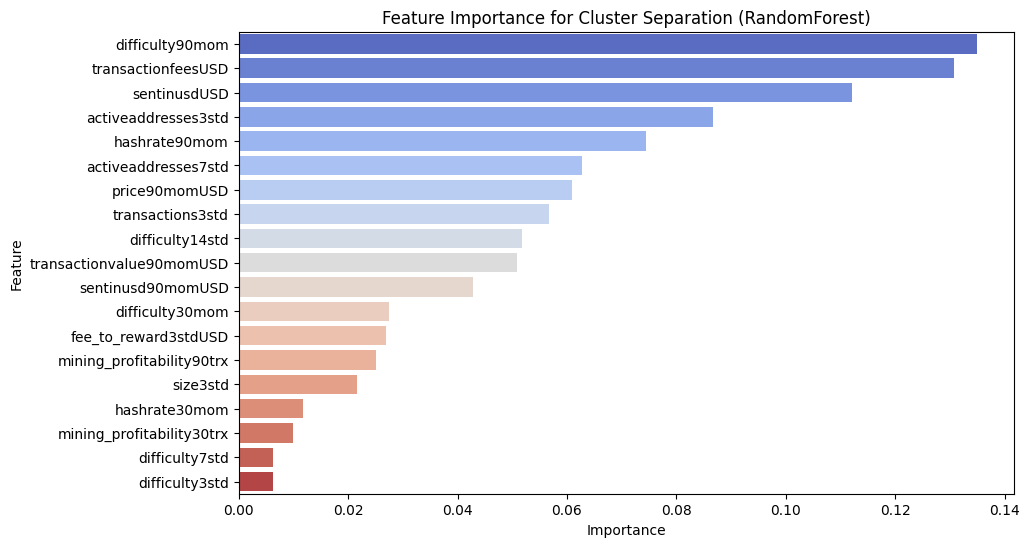

In [14]:

# ------------------------- Feature Importance Analysis -------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, clusters_kmeans)
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance based on RandomForest Classifier on KMeans clusters:")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title("Feature Importance for Cluster Separation (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [15]:

# ------------------------- PCA Comparison Summary -------------------------
print("\n===== PCA Comparison Summary =====")
print("PCA BEFORE Outlier Removal - Explained Variance Ratio:", pca_before.explained_variance_ratio_)
print("PCA AFTER Outlier Removal  - Explained Variance Ratio:", pca_after.explained_variance_ratio_)
print("\nObservations:")
print("- The PCA BEFORE plot shows the overall spread of the data, including potential outliers that may distort the variance distribution.")
print("- The PCA AFTER plot (only inliers) often shows a more consolidated or distinct clustering structure, which might help in revealing the true underlying pattern without the noise introduced by extreme values.")
print("- Comparing the explained variance ratios can indicate if the outlier removal has concentrated more variance into the leading components (often a sign of reduced noise).")



===== PCA Comparison Summary =====
PCA BEFORE Outlier Removal - Explained Variance Ratio: [0.25960512 0.12548627]
PCA AFTER Outlier Removal  - Explained Variance Ratio: [0.31417999 0.14477055]

Observations:
- The PCA BEFORE plot shows the overall spread of the data, including potential outliers that may distort the variance distribution.
- The PCA AFTER plot (only inliers) often shows a more consolidated or distinct clustering structure, which might help in revealing the true underlying pattern without the noise introduced by extreme values.
- Comparing the explained variance ratios can indicate if the outlier removal has concentrated more variance into the leading components (often a sign of reduced noise).


In [16]:
# ------------------------- Comparison and Evaluation -------------------------
print("\n📊 Comparison of ML Algorithms:")

print("\n-- KMeans Clustering --")
print(f"Silhouette Score: {silhouette_kmeans:.4f}")
print("Pros: Easy to interpret; good for spherical clusters if silhouette score is high.")
print("Cons: Needs pre-specification of k; sensitive to outliers.")

print("\n-- DBSCAN Clustering --")
if silhouette_dbscan is not None:
    print(f"Silhouette Score (non-noise points): {silhouette_dbscan:.4f}")
    print("Pros: Automatically detects clusters; handles non-spherical clusters and noise points.")
    print("Cons: Parameter sensitive; may not form clusters if parameters are not tuned.")
else:
    print("DBSCAN did not form sufficient clusters with the current parameters.")

print("\n-- Isolation Forest for Outlier Detection --")
print(f"Outlier Ratio: {outlier_ratio:.2%}")
print("Pros: Tailored for anomaly detection; robust distance-based method.")
print("Cons: Not intended for clustering; does not provide cluster separation.")


📊 Comparison of ML Algorithms:

-- KMeans Clustering --
Silhouette Score: 0.2849
Pros: Easy to interpret; good for spherical clusters if silhouette score is high.
Cons: Needs pre-specification of k; sensitive to outliers.

-- DBSCAN Clustering --
Silhouette Score (non-noise points): -0.1763
Pros: Automatically detects clusters; handles non-spherical clusters and noise points.
Cons: Parameter sensitive; may not form clusters if parameters are not tuned.

-- Isolation Forest for Outlier Detection --
Outlier Ratio: 5.01%
Pros: Tailored for anomaly detection; robust distance-based method.
Cons: Not intended for clustering; does not provide cluster separation.


In [17]:

# ------------------------- Final Save -------------------------
df.to_csv("BTC_with_all_algo_results.csv", index=False)
print("\nFinal results saved as 'BTC_with_all_algo_results.csv'.")



Final results saved as 'BTC_with_all_algo_results.csv'.
